In [19]:
# plot results
import config
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2 as cv


results_dir = config.EVAL_IMG_PATHS 
#results_dir = '/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm/eval_images3/'
results_dir =  '/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/'

print('results in:', results_dir)

results in: /Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/


In [13]:
gtMasks = glob(results_dir + '*gtMask*')
images = glob(results_dir + '*image*')
gtMasks = glob(results_dir + '*predMask*')

gtMasks[:3], images[:3], gtMasks[:3]

(['/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/predMask_0_batch8.png',
  '/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/predMask_0_batch31.png',
  '/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/predMask_0_batch25.png'],
 ['/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/image_0_batch43.png',
  '/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/image_0_batch57.png',
  '/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/image_1_batch11.png'],
 ['/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/predMask_0_batch8.png',
  '/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1/predMask_0_batch31.png',
  '/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/multiClassWorm256/eval_images_1

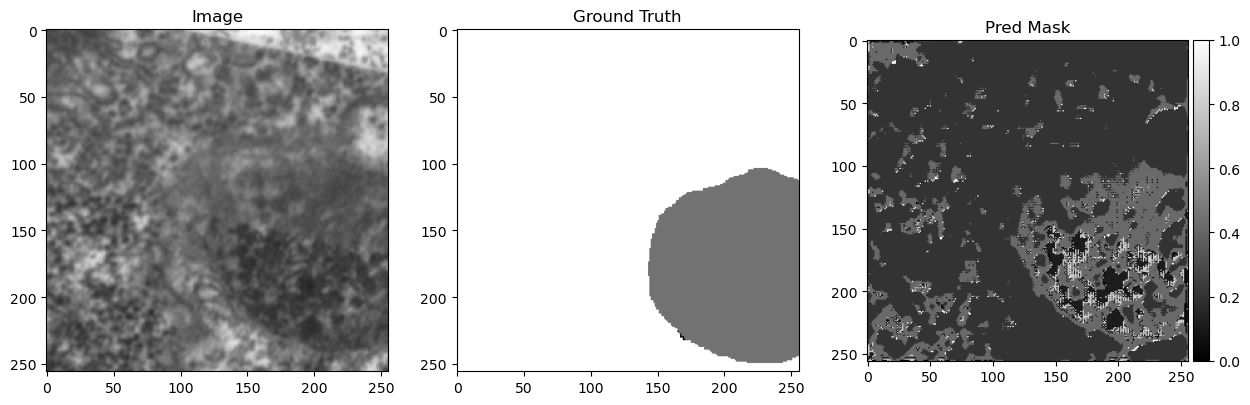

In [14]:
# plot them
nsize = 1 # how many to plot

inds = np.random.choice(np.arange(0,len(gtMasks)),nsize, replace=False)
inds = [98]

base = 5
fig,ax = plt.subplots(nsize, 3, figsize=(base*3, nsize*base))
if len(ax.shape) == 1:
    ax = [ax]

for i,ind in enumerate(inds):
    img_file = images[ind]
    gt_file = img_file.replace('image_', 'gtMask_')
    pred_file = img_file.replace('image_', 'predMask_')
    img = np.array(Image.open(img_file).convert('RGB')).astype('float')
    img /= img.max()
    gt = np.array(Image.open(gt_file).convert('RGB')).astype('float')
    gt /= gt.max()
    pred = np.array(Image.open(pred_file).convert('RGB')).astype('float')
    pred /= pred.max()
    ax[i][0].imshow(img)
    ax[i][0].set_title('Image')
    ax[i][1].imshow(gt)
    ax[i][1].set_title('Ground Truth')
    im = ax[i][2].imshow(pred, cmap='gray')
    ax[i][2].set_title('Pred Mask')
    divider = make_axes_locatable(ax[i][2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation = 'vertical')#, cmap='gray')

plt.show()


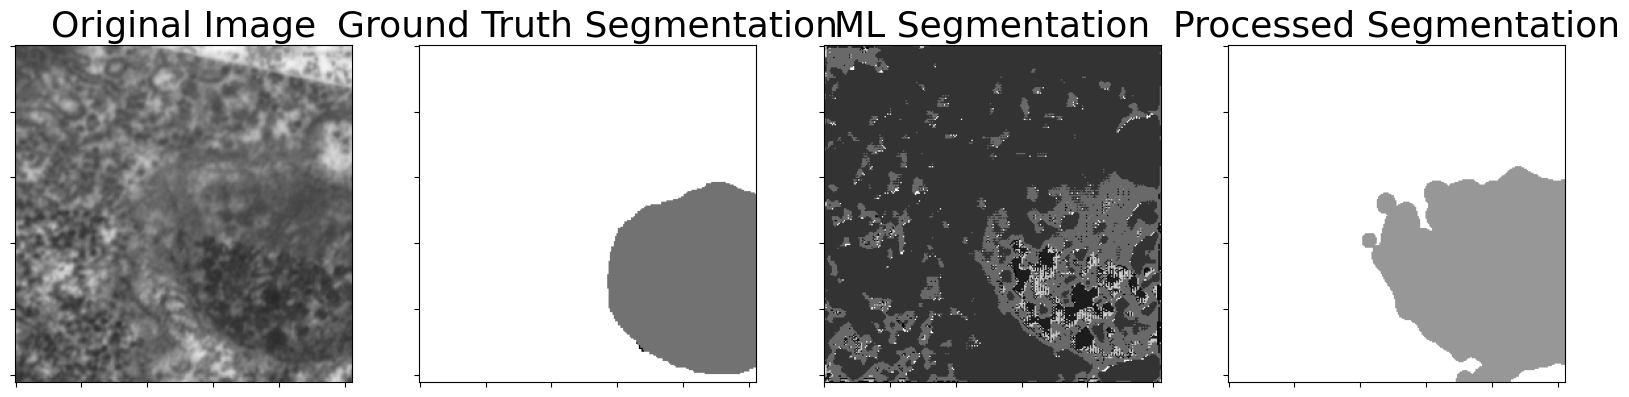

In [89]:
# processing for contours
ind_c = 98 # nice one

fontsize_t = 26


base = 5
nPlots = 4
fig,ax = plt.subplots(1, nPlots, figsize=(base*nPlots, 1*base))

img_file = images[ind_c]
gt_file = img_file.replace('image_', 'gtMask_')
pred_file = img_file.replace('image_', 'predMask_')
img = np.array(Image.open(img_file).convert('RGB')).astype('float')
img /= img.max()
gt = np.array(Image.open(gt_file).convert('RGB')).astype('float')
gt /= gt.max()
pred = np.array(Image.open(pred_file).convert('RGB')).astype('float')
pred /= pred.max()
ax[0].imshow(img)
ax[0].set_title('Original Image', fontsize=fontsize_t)
ax[1].imshow(gt)
ax[1].set_title('Ground Truth Segmentation', fontsize=fontsize_t)
im = ax[2].imshow(pred, cmap='gray')
ax[2].set_title('ML Segmentation', fontsize=fontsize_t)
# divider = make_axes_locatable(ax[2])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation = 'vertical')


# processing for map
kernel = (11,11)
imgP = cv.GaussianBlur((pred.copy()*255).astype('uint8'), kernel, 0)
gray = cv.cvtColor(imgP, cv.COLOR_RGB2GRAY)

# binner = cv.Canny(gray, 0, 50, apertureSize=5)
# binner = cv.dilate(binner, None)
thrs = 75
_retval, binner = cv.threshold(gray, thrs, 255, cv.THRESH_BINARY)

# dilate
binner_d = cv.GaussianBlur(binner,kernel,0)

contours, _hierarchy = cv.findContours(binner_d, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

# drop small contours
pixel_check = 7000
contours_save = []
for cnt in contours:
    #print(cnt)
    cnt_len = cv.arcLength(cnt, True)
    cnt_chk = cv.approxPolyDP(cnt, 0.02*cnt_len, True)
    if cv.contourArea(cnt_chk) > pixel_check: # and cv.isContourConvex(cnt):
        contours_save.append(cnt)


imgPlot = gray.copy()
imgPlot[:,:] = 255

# get mean value inside mask
#img_mask = 255 - imgPlot.copy()
gray_avg = cv.cvtColor((pred.copy()*255).astype('uint8'), cv.COLOR_RGB2GRAY)

#img_avg = gray_avg*img_mask

img_cont = cv.drawContours(imgPlot, contours_save, -1, (0,255,0), -1)

img_mask = 255-img_cont.copy()
img_avg = gray_avg*img_mask
img_cont[img_cont == 0] = np.median(img_avg[img_avg>0])



ax[3].imshow(img_cont, cmap='gray',vmin=0,vmax=255)
ax[3].set_title('Processed Segmentation', fontsize=fontsize_t)


# turn off labels

for a in fig.axes:
    a.xaxis.set_ticklabels([])
    a.yaxis.set_ticklabels([])

#plt.show()

fig.tight_layout()
fig.savefig('/Users/jnaiman/Downloads/tmp/wormfindr/wormOntologyNSF/example_segment.pdf',bbox_inches='tight')



In [78]:
np.mean(img_avg[img_avg>0])

170.31528907452187

In [68]:
#imgP

In [10]:
#array([62,  4,  0, 41, 33, 32, 44, 53, 45, 42, 14, 13, 63, 26, 17, 16, 38, 12,  3, 47])
inds[12]

98

In [39]:
ax.shape

(3,)